In [2460]:
import pandas as pd
import sklearn
import numpy as np
from sklearn import datasets, linear_model
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel


from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_predict

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.decomposition import PCA

from sklearn.feature_selection import RFECV 

from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import PolynomialFeatures

In [2461]:
all_df = pd.read_csv('TrainDataset2024.csv', index_col = False)
all_df.head()
len(all_df.index)

400

In [2462]:
#****PREPROCESSING****

In [2463]:
y= all_df["RelapseFreeSurvival (outcome)"]
X = all_df.drop(['ID', "pCR (outcome)", "RelapseFreeSurvival (outcome)"], axis=1)



imputer = SimpleImputer(missing_values=999, strategy="median")
imputer.set_output(transform="pandas")
X = imputer.fit_transform(X)

In [2464]:
columns = X.columns
medians = {}
# Need to save the training set medians so that test set can be mutated accordingly
for column in columns:
    medians[column] = X[column].median()



def replace_outliers_with_median(df):
    columns = df.columns 
    for column in columns:
        Q1 = df[column].quantile(0.25) 
        Q3 = df[column].quantile(0.75)  
        IQR = Q3 - Q1                  
        lower_bound = Q1 - 1.5 * IQR   
        upper_bound = Q3 + 1.5 * IQR   
        median = df[column].median()  
        
        df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)



replace_outliers_with_median(X)

In [2465]:
#One Hot Encoding
#following https://www.geeksforgeeks.org/ml-one-hot-encoding/

#-chemoGrade
#-proliferation
#-histology type
#-tumorStage


categorical_columns = ['ChemoGrade','Proliferation','HistologyType','TumourStage']

encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(X[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, 
                          columns=encoder.get_feature_names_out(categorical_columns))

#X after all categorical values have been one hot encoded
one_hot_X = pd.concat([X.drop(categorical_columns, axis=1), one_hot_df], axis=1)

print(one_hot_X.columns)


Index(['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'LNStatus', 'Gene',
       'original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength',
       ...
       'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0',
       'Proliferation_2.0', 'Proliferation_3.0', 'HistologyType_1.0',
       'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0',
       'TumourStage_4.0'],
      dtype='object', length=125)


<Axes: >

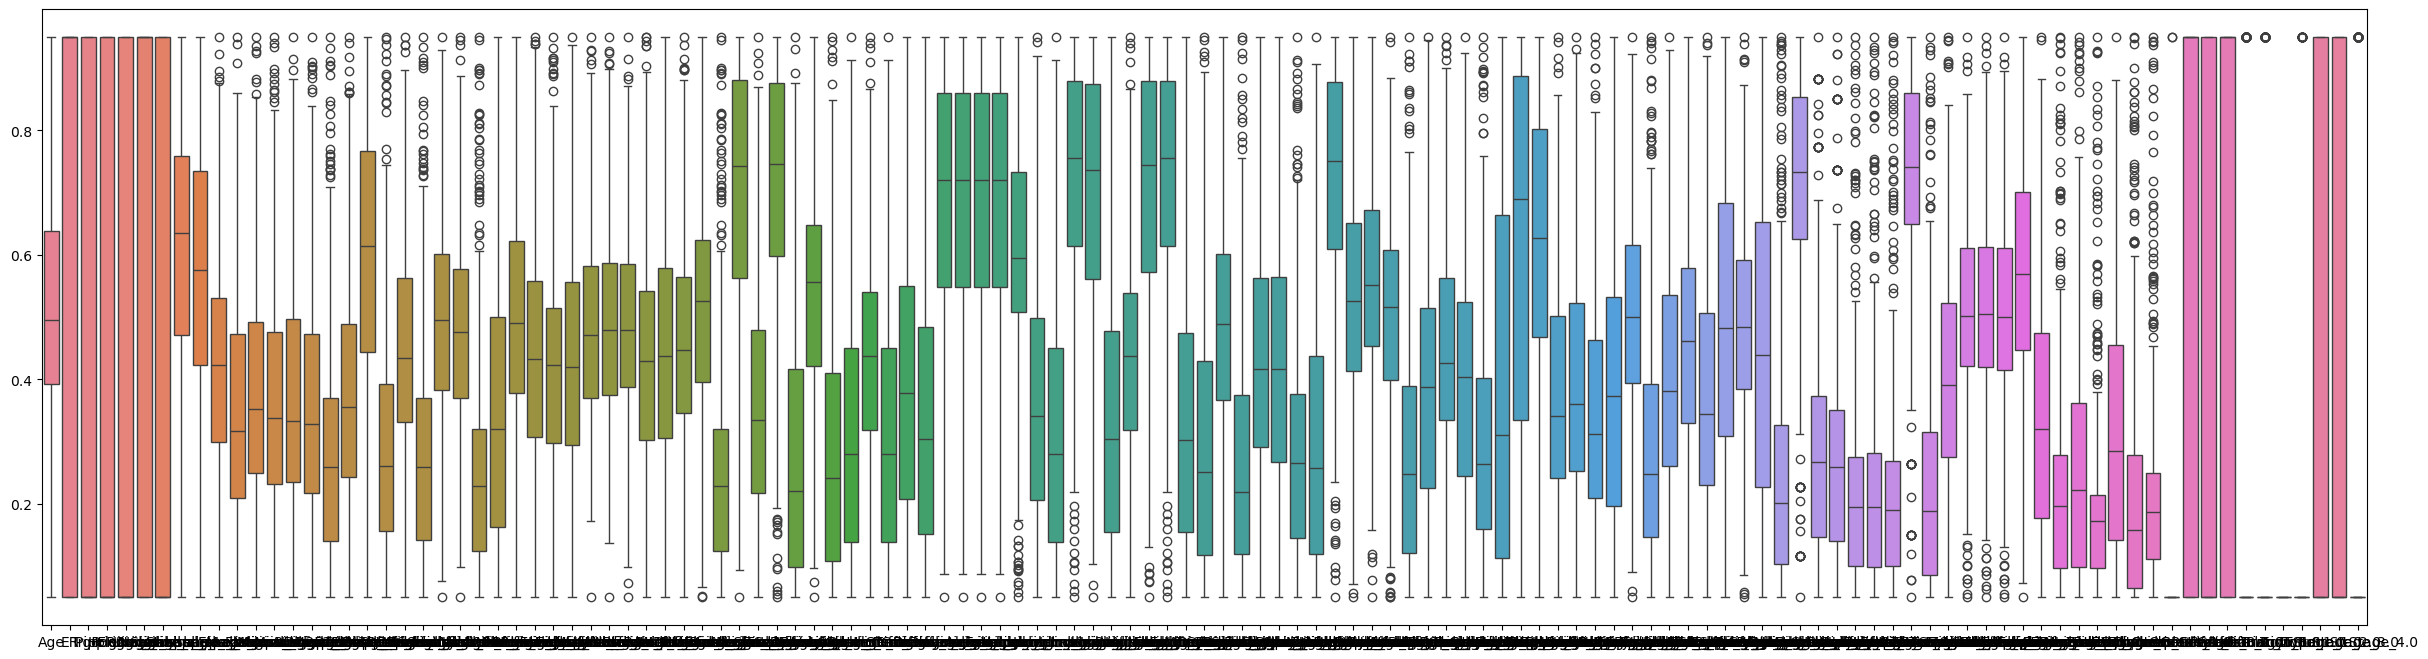

In [2466]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0.05,0.95), clip=False)
scaler.set_output(transform="pandas")
Xs = scaler.fit_transform(one_hot_X)

from matplotlib import pyplot as plt
import seaborn as sns

fig,ax = plt.subplots(1,figsize=(30,8))
sns.boxplot(data=Xs,ax=ax)


#?testing Y scaling



<Axes: >

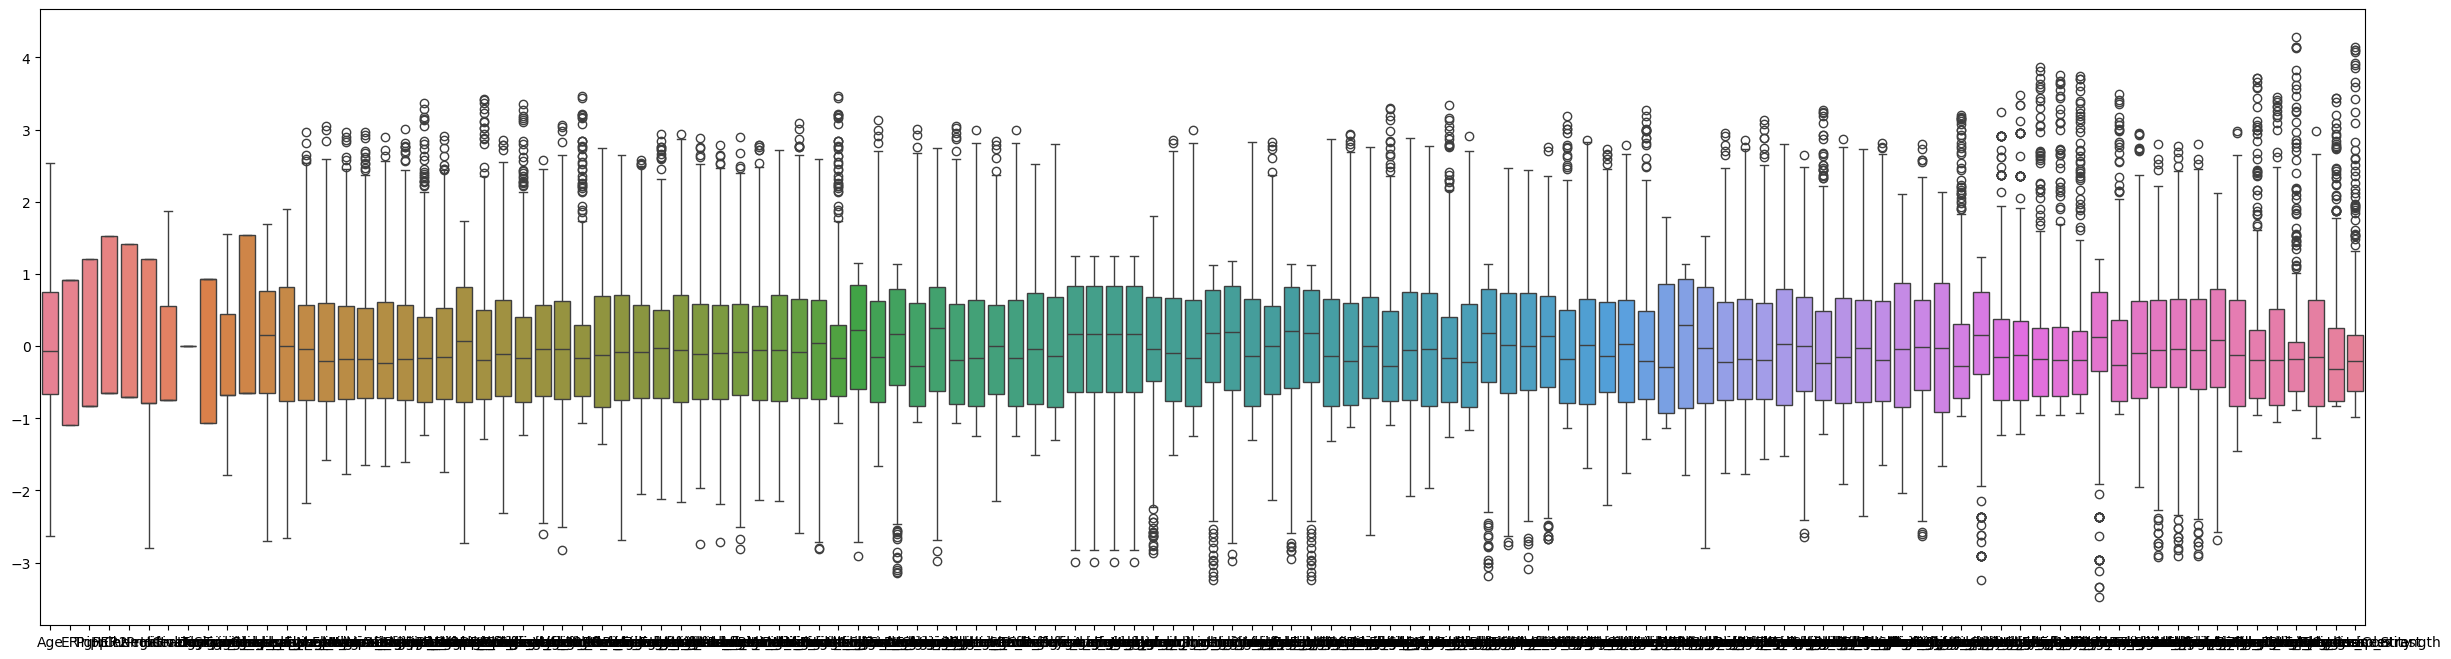

In [2467]:
#standard scaler

#Hasn't given great success
scaler = StandardScaler()
scaler.set_output(transform="pandas")
std_Xs = scaler.fit_transform(X)


fig,ax = plt.subplots(1,figsize=(30,8))
sns.boxplot(data=std_Xs,ax=ax)

#print(y)

#@CHANGE FROM XS to STD_XS
#Xs=std_Xs#!ON


In [2468]:
#****FEATURE SELECTION****

In [2469]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(Xs)

print("Original number of features:", X.shape[1])
print("Expanded number of features:", X_poly.shape[1])

Original number of features: 118
Expanded number of features: 8000


In [2470]:
'''
#TEST LASSO
param_grid = {
    'alpha': [0.001, 0.01, 0.1],
}
grid = GridSearchCV(Lasso(tol=1e-2), param_grid, cv=kf, scoring='neg_mean_absolute_error')
grid.fit(X_poly, y)
print("Best Lasso parameters:", grid.best_params_)
print("best score", -grid.best_score_)
'''

'\n#TEST LASSO\nparam_grid = {\n    \'alpha\': [0.001, 0.01, 0.1],\n}\ngrid = GridSearchCV(Lasso(tol=1e-2), param_grid, cv=kf, scoring=\'neg_mean_absolute_error\')\ngrid.fit(X_poly, y)\nprint("Best Lasso parameters:", grid.best_params_)\nprint("best score", -grid.best_score_)\n'

In [2471]:
'''
#TEST RF regressor
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=kf, scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)
print("Best RF parameters:", grid.best_params_)
print("best score", -grid.best_score_)
'''

'\n#TEST RF regressor\nparam_grid = {\n    \'n_estimators\': [10, 50, 100, 200, 500],\n    \'max_features\': [\'sqrt\', \'log2\', None],\n    \'max_depth\': [10, 20, 30, None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\ngrid = GridSearchCV(RandomForestRegressor(), param_grid, cv=kf, scoring=\'neg_mean_absolute_error\')\ngrid.fit(X_train, y_train)\nprint("Best RF parameters:", grid.best_params_)\nprint("best score", -grid.best_score_)\n'

In [2472]:

'''
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'max_features': [0.25, 0.5, 0.75]
}
grid = GridSearchCV(GradientBoostingRegressor(loss='absolute_error'), param_grid, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best MLP parameters:", grid.best_params_)
print("best score", -grid.best_score_)
'''


'\nparam_grid = {\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.2],\n    \'n_estimators\': [100, 200, 500, 1000],\n    \'max_depth\': [3, 5, 7, 10],\n    \'max_features\': [0.25, 0.5, 0.75]\n}\ngrid = GridSearchCV(GradientBoostingRegressor(loss=\'absolute_error\'), param_grid, cv=kf, scoring=\'neg_mean_absolute_error\', n_jobs=-1)\ngrid.fit(X_train, y_train)\nprint("Best MLP parameters:", grid.best_params_)\nprint("best score", -grid.best_score_)\n'

In [2564]:
max_features = 20

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

#Lasso 
#following  https://www.geeksforgeeks.org/how-to-perform-feature-selection-for-regression-data/


lasso = Lasso(alpha=0.1, tol=1e-2)

lasso.fit(X_poly,y)



#----------------------------------------------------

#Random Forest
#rfRegressor = RandomForestRegressor(n_estimators=500, random_state=42)

#rfRegressor.fit(X_poly,y)


#------------------------------------------------------
#Gradient Boosting

gbRegressor = GradientBoostingRegressor(loss='absolute_error', learning_rate=0.01, max_depth=3, max_features=0.25, n_estimators=100)
gbRegressor.fit(X_poly,y)


GradientBoostingRegressor(learning_rate=0.01, loss='absolute_error',
                          max_features=0.25)

In [2565]:
'''
result = permutation_importance(gbRegressor, Xs, y, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
importances = result.importances_mean
sorted_indices = importances.argsort()[::-1]

for i in sorted_indices:
  print(f"Feature {Xs.columns[i]}: Importance {importances[i]:.4f}")
'''

'\nresult = permutation_importance(gbRegressor, Xs, y, n_repeats=10, random_state=42, scoring=\'neg_mean_squared_error\')\nimportances = result.importances_mean\nsorted_indices = importances.argsort()[::-1]\n\nfor i in sorted_indices:\n  print(f"Feature {Xs.columns[i]}: Importance {importances[i]:.4f}")\n'

In [2566]:
#RFE
'''
#hasn't shown great success

selector = RFECV(lasso, cv=kf, min_features_to_select=20, scoring='neg_mean_absolute_error') 
selector = selector.fit(Xs, y) 

feature_names=Xs.columns
rfe_feature_importance = pd.Series(selector.support_, index=feature_names)

print("Features: ", rfe_feature_importance[rfe_feature_importance ==True].size)
print(rfe_feature_importance[rfe_feature_importance ==True])
'''

'\n#hasn\'t shown great success\n\nselector = RFECV(lasso, cv=kf, min_features_to_select=20, scoring=\'neg_mean_absolute_error\') \nselector = selector.fit(Xs, y) \n\nfeature_names=Xs.columns\nrfe_feature_importance = pd.Series(selector.support_, index=feature_names)\n\nprint("Features: ", rfe_feature_importance[rfe_feature_importance ==True].size)\nprint(rfe_feature_importance[rfe_feature_importance ==True])\n'

In [2567]:

#with lasso max_features=20
#with rForest +poly max_features = 50
#with GB +poly max_features = 100

#SelectFromModel
model = SelectFromModel(gbRegressor, prefit=True, max_features=100) #with lasso currently max_features=20

#Recursive Feature Elimination

'''
feature_names=Xs.columns
feature_importance = pd.Series(model.get_support(), index=feature_names)



#nicer ways of doing this
feature_importance['ER']=True
feature_importance['HER2']=True
feature_importance['Gene']=True

print("Features: ", feature_importance[feature_importance ==True].size)
print(feature_importance[feature_importance ==True])


reduced_Xs = Xs.drop(feature_importance.loc[feature_importance ==False].index, axis = 1)

'''
#!CHANGE
val_test=model.get_support(indices=True)

X_poly_reduced = X_poly[:, val_test]

print(val_test.size)

reduced_Xs = X_poly_reduced #!CHANGE


100


In [2568]:
#Some PCA?
pca = PCA(n_components=0.5)
X_pca = pca.fit_transform(reduced_Xs)

print(X_pca)

[[-0.99177701  1.0077777   0.82755502  0.26180055]
 [-0.55152263 -0.46414244  0.30808388 -0.06024582]
 [ 0.59504133  1.3750779   0.52946226 -0.61877441]
 ...
 [ 0.9121167  -0.35948183  0.69706841 -0.49402917]
 [-0.71731827 -0.46705735 -0.60932702  0.04739822]
 [ 0.98195138 -0.33990074  0.59052361 -0.32967958]]


In [2569]:


X_train, X_test, y_train, y_test = train_test_split(reduced_Xs, y, test_size=0.4, random_state=42) 

pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(X_pca, y, test_size=0.4, random_state=42)

scaler_y = MinMaxScaler(feature_range=(0.05, 0.95))
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)


In [2570]:
#****MODEL_EVALUATION****

In [2571]:
#X_train, X_test, y_train, y_test = train_test_split(reduced_Xs, y, test_size=0.3, random_state=42)


#baseline, should be considerably better than this
baseline = -cross_val_score(DummyRegressor(strategy="mean"), X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()

# multi-layer perceptron neural network without pca
mlp = -cross_val_score(MLPRegressor(max_iter=5000, alpha = 0.0001, solver = 'adam', hidden_layer_sizes=(50,), learning_rate_init = 0.001), 
                       X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mlp_score = mlp.mean()

linear_regression = -cross_val_score(LinearRegression(),X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
linear_regression_score = linear_regression.mean()

# decision tree without pca
decision_tree = -cross_val_score(DecisionTreeRegressor(), X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
decision_tree_score = decision_tree.mean()

svm = -cross_val_score(SVR(C=100, epsilon=0.5, gamma=1, kernel= 'rbf'), X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
svm_score = svm.mean()

gbr = -cross_val_score(GradientBoostingRegressor(loss='absolute_error', learning_rate=0.1, n_estimators=300, max_depth = 1, 
                                                 random_state = 42, max_features = 5),
                       X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
gbr_score=gbr.mean()


print("Baseline:", baseline)
print("MLP:", mlp_score)
print("Linear regression", linear_regression_score)
print("Decision tree:", decision_tree_score)
print("SVM: ", svm_score)
print("GBR: ", gbr_score)

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optim

Baseline: 709.1387255982687
MLP: 896.5756091704914
Linear regression 1319.5404712182985
Decision tree: 1359.4224536979145
SVM:  658.7696834346459
GBR:  653.5760894035586


In [2572]:
#PCA TESTS


#baseline, should be considerably better than this
baseline = -cross_val_score(DummyRegressor(strategy="mean"), pca_X_train, pca_y_train, cv=kf, scoring='neg_mean_absolute_error').mean()

# multi-layer perceptron neural network without pca
mlp = -cross_val_score(MLPRegressor(max_iter=1000, alpha = 0.0001, solver = 'adam', hidden_layer_sizes=(50,), learning_rate_init = 0.001), 
                       pca_X_train, pca_y_train, cv=kf, scoring='neg_mean_absolute_error')
mlp_score = mlp.mean()

linear_regression = -cross_val_score(LinearRegression(),pca_X_train, pca_y_train, cv=kf, scoring='neg_mean_absolute_error')
linear_regression_score = linear_regression.mean()

# decision tree without pca
decision_tree = -cross_val_score(DecisionTreeRegressor(), pca_X_train, pca_y_train, cv=kf, scoring='neg_mean_absolute_error')
decision_tree_score = decision_tree.mean()

svm = -cross_val_score(SVR(C=100, epsilon=0.5, gamma=1, kernel= 'rbf'), pca_X_train, pca_y_train, cv=kf, scoring='neg_mean_absolute_error')
svm_score = svm.mean()

gbr = -cross_val_score(GradientBoostingRegressor(loss='absolute_error', learning_rate=0.1, n_estimators=300, max_depth = 1, 
                                                 random_state = 42, max_features = 5),
                       pca_X_train, pca_y_train, cv=kf, scoring='neg_mean_absolute_error')
gbr_score=gbr.mean()


print("Baseline:", baseline)
print("MLP:", mlp_score)
print("Linear regression", linear_regression_score)
print("Decision tree:", decision_tree_score)
print("SVM: ", svm_score)
print("GBR: ", gbr_score)

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optim

Baseline: 20.822941984921005
MLP: 20.812087651360294
Linear regression 20.16423849354784
Decision tree: 27.109027777583332
SVM:  21.631625136407642
GBR:  20.8956681209371


In [2573]:
'''
param_grid = {
    'C': [0.1, 1, 10, 50, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'epsilon': [0.1, 0.2, 0.5]
    
}
grid = GridSearchCV(SVR(), param_grid, cv=kf, scoring='neg_mean_absolute_error')
grid.fit(pca_X_train, pca_y_train)
print("Best SVM parameters:", grid.best_params_)
print("best score", -grid.best_score_)
'''

'\nparam_grid = {\n    \'C\': [0.1, 1, 10, 50, 100],\n    \'kernel\': [\'linear\', \'rbf\', \'poly\'],\n    \'gamma\': [\'scale\', \'auto\', 0.01, 0.1, 1],\n    \'epsilon\': [0.1, 0.2, 0.5]\n    \n}\ngrid = GridSearchCV(SVR(), param_grid, cv=kf, scoring=\'neg_mean_absolute_error\')\ngrid.fit(pca_X_train, pca_y_train)\nprint("Best SVM parameters:", grid.best_params_)\nprint("best score", -grid.best_score_)\n'

In [2574]:
'''
#!COMMENT OUT AFTER USING
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    #'activation': ['tanh', 'relu']
}
grid = GridSearchCV(MLPRegressor(max_iter=5000), param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train_scaled)
print("Best MLP parameters:", grid.best_params_)
print("best score", -grid.best_score_)
'''

'\n#!COMMENT OUT AFTER USING\nparam_grid = {\n    \'hidden_layer_sizes\': [(50,), (100,), (50, 50), (100, 50), (100, 100)],\n    \'solver\': [\'lbfgs\', \'sgd\', \'adam\'],\n    \'alpha\': [0.0001, 0.001, 0.01, 0.1],\n    \'learning_rate_init\': [0.001, 0.01, 0.1],\n    #\'activation\': [\'tanh\', \'relu\']\n}\ngrid = GridSearchCV(MLPRegressor(max_iter=5000), param_grid, cv=kf, scoring=\'neg_mean_squared_error\', n_jobs=-1)\ngrid.fit(X_train, y_train_scaled)\nprint("Best MLP parameters:", grid.best_params_)\nprint("best score", -grid.best_score_)\n'

0.05686366625569661
21.328009367962434
754.5497292588735


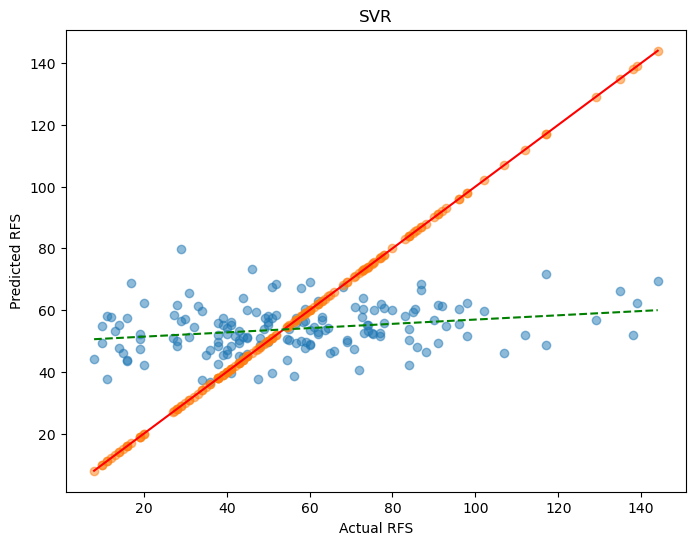

In [2575]:
#SVR_predictor = SVR(C=50, epsilon=0.5, gamma=0.1, kernel= 'rbf')
SVR_predictor = SVR(C=20, epsilon=0.5, gamma=0.1, kernel= 'rbf')



SVR_predictor.fit(X_train, y_train)


svr_result = SVR_predictor.predict(X_test)



#predictions = cross_val_predict(SVR_test, reduced_Xs, y, cv=kf)

print(SVR_predictor.score(X_test, y_test))
print(mean_absolute_error(y_test, svr_result))
print(mean_squared_error(y_test, svr_result))

# Predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_result, alpha=0.5)
plt.scatter(y_test, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r') 
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, svr_result, 1))(np.unique(y_test)), 'g--')
plt.xlabel("Actual RFS")
plt.ylabel("Predicted RFS")
plt.title("SVR")
plt.show()



0.05472853296279778
21.82522637610715
756.2579279470657


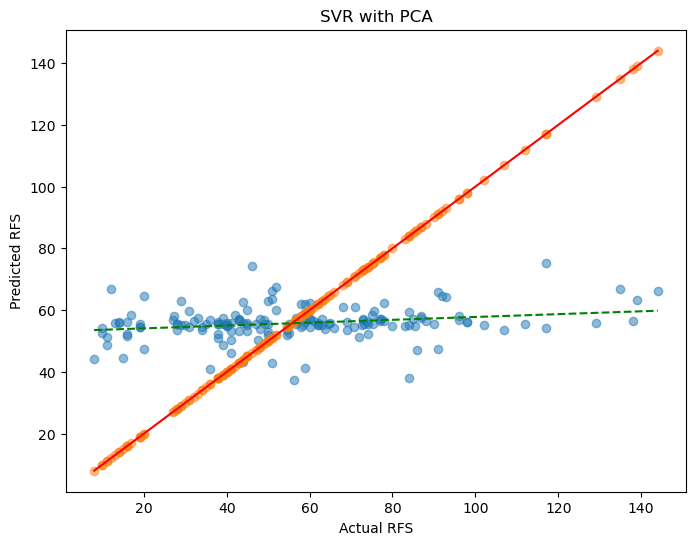

In [2576]:
pca_SVR_predictor = SVR(C=50, epsilon=0.1, gamma='auto', kernel= 'poly')



pca_SVR_predictor.fit(pca_X_train, pca_y_train)


pca_svr_result = pca_SVR_predictor.predict(pca_X_test)



#predictions = cross_val_predict(SVR_test, reduced_Xs, y, cv=kf)

print(pca_SVR_predictor.score(pca_X_test, pca_y_test))
print(mean_absolute_error(pca_y_test, pca_svr_result))
print(mean_squared_error(pca_y_test, pca_svr_result))

# Predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(pca_y_test, pca_svr_result, alpha=0.5)
plt.scatter(pca_y_test, pca_y_test, alpha=0.5)
plt.plot([pca_y_test.min(), pca_y_test.max()], [pca_y_test.min(), pca_y_test.max()], 'r') 
plt.plot(np.unique(pca_y_test), np.poly1d(np.polyfit(pca_y_test, pca_svr_result, 1))(np.unique(pca_y_test)), 'g--')
plt.xlabel("Actual RFS")
plt.ylabel("Predicted RFS")
plt.title("SVR with PCA")
plt.show()


0.044558907829843286
21.33229914723588
764.3940665053915


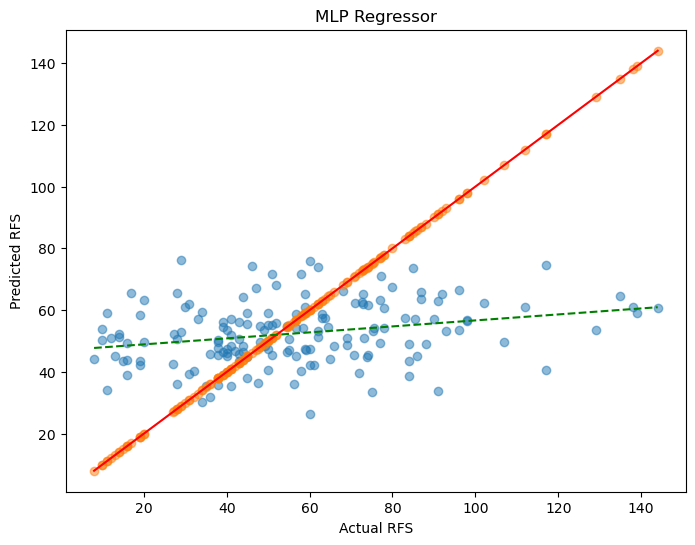

In [2577]:
#working params: MLPRegressor(max_iter=2000, alpha = 0.0001, solver = 'adam', hidden_layer_sizes=(50,), learning_rate_init = 0.001)

#{'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'adam'} with Lasso (+important value)
#{'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'adam'} with Lasso
#{'alpha': 0.1, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'solver': 'adam'} with gbRegression

MLP_predictor = MLPRegressor(max_iter=5000, alpha = 0.001, solver = 'adam', 
                             hidden_layer_sizes=(50,), learning_rate_init = 0.001)

MLP_predictor.fit(X_train, y_train)


mlp_result = MLP_predictor.predict(X_test)


print(MLP_predictor.score(X_test, y_test))
print(mean_absolute_error(y_test, mlp_result))
print(mean_squared_error(y_test, mlp_result))

#predictions = cross_val_predict(SVR_test, reduced_Xs, y, cv=kf)

# Predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, mlp_result, alpha=0.5)
plt.scatter(y_test, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r') 
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, mlp_result, 1))(np.unique(y_test)), 'g--')
plt.xlabel("Actual RFS")
plt.ylabel("Predicted RFS")
plt.title("MLP Regressor")
plt.show()

0.045862059945447564
21.970982446061683
763.3514886289687


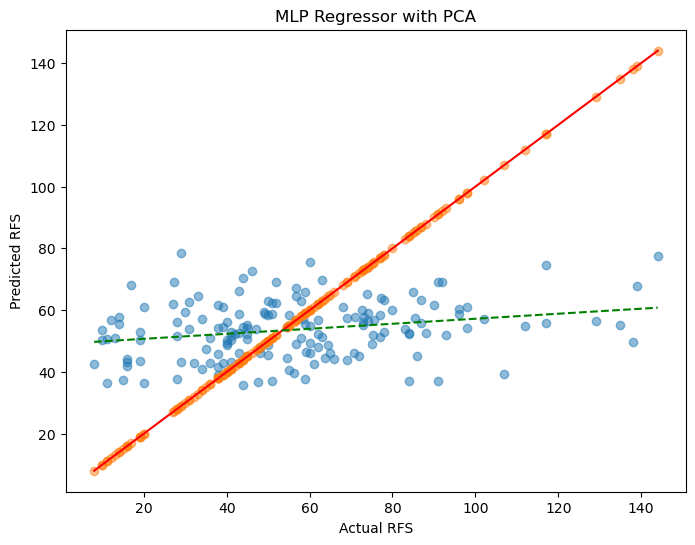

In [2578]:
#MLP WITH PCA
#Best MLP parameters: {'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}
pca_MLP_predictor = MLPRegressor(max_iter=5000, alpha = 0.1, solver = 'adam', hidden_layer_sizes=(50,), learning_rate_init = 0.01)

pca_MLP_predictor.fit(pca_X_train, pca_y_train)


pca_mlp_result = pca_MLP_predictor.predict(pca_X_test)


print(pca_MLP_predictor.score(pca_X_test, pca_y_test))
print(mean_absolute_error(pca_y_test, pca_mlp_result))
print(mean_squared_error(pca_y_test, pca_mlp_result))

#predictions = cross_val_predict(SVR_test, reduced_Xs, y, cv=kf)

# Predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(pca_y_test, pca_mlp_result, alpha=0.5)
plt.scatter(pca_y_test, pca_y_test, alpha=0.5)
plt.plot([pca_y_test.min(), pca_y_test.max()], [pca_y_test.min(), pca_y_test.max()], 'r') 
plt.plot(np.unique(pca_y_test), np.poly1d(np.polyfit(pca_y_test, pca_mlp_result, 1))(np.unique(pca_y_test)), 'g--')
plt.xlabel("Actual RFS")
plt.ylabel("Predicted RFS")
plt.title("MLP Regressor with PCA")
plt.show()

0.0970837926821233
20.49206476095149
722.371894072168


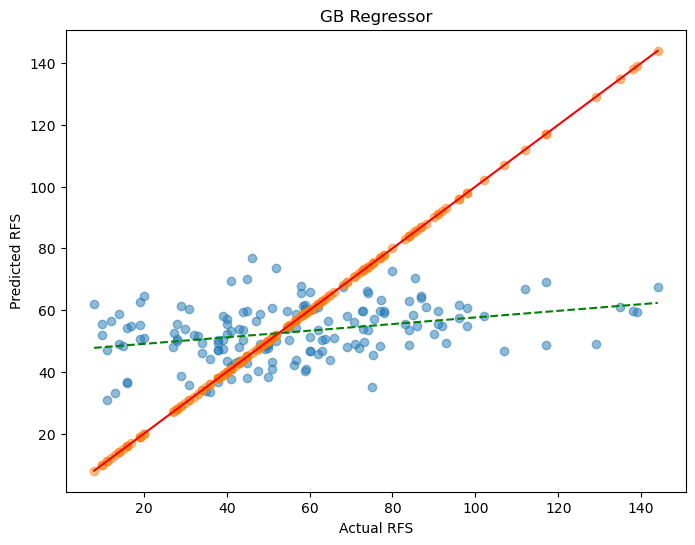

In [2579]:
#GBR
#GradientBoostingRegressor(loss='loss='absolute_error', learning_rate=0.1, n_estimators=300, 
#                                                          max_depth = 2, random_state = 42, max_features = 10)

GBR_predictor = GradientBoostingRegressor(loss='absolute_error', learning_rate=0.1, n_estimators=300, 
                                                          max_depth = 3, random_state = 42, max_features = 10)

GBR_predictor.fit(X_train, y_train)


gbr_result = GBR_predictor.predict(X_test)


print(GBR_predictor.score(X_test, y_test))
print(mean_absolute_error(y_test, gbr_result))
print(mean_squared_error(y_test, gbr_result))

#predictions = cross_val_predict(SVR_test, reduced_Xs, y, cv=kf)

# Predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, gbr_result, alpha=0.5)
plt.scatter(y_test, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r') 
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, gbr_result, 1))(np.unique(y_test)), 'g--')
plt.xlabel("Actual RFS")
plt.ylabel("Predicted RFS")
plt.title("GB Regressor")
plt.show()

#RF FS max_features=50 = 0.16
#

#GB no max = 0.109
#max=100 = 0.147

-0.001107951756922132
22.145243055554168
800.929523050149


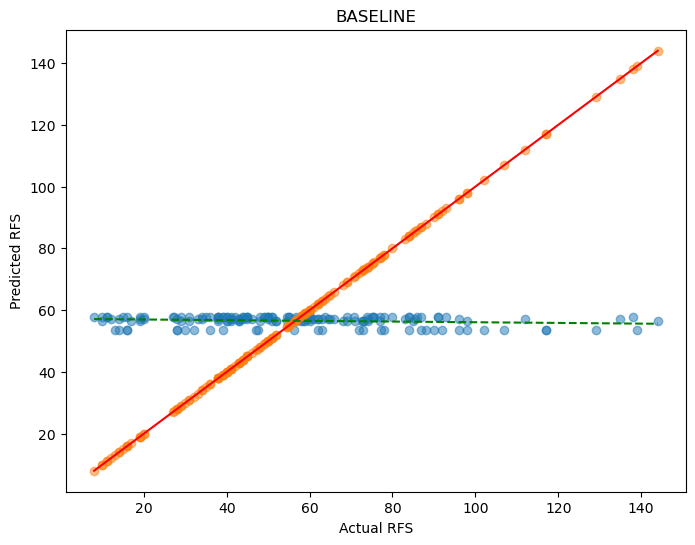

In [2580]:
#dummy regressor

predictions = cross_val_predict(DummyRegressor(), X_test, y_test, cv=kf)

testReg = DummyRegressor()
testReg.fit(X_train, y_train)

dmy_result = testReg.predict(y_test)

print(testReg.score(X_test, y_test))

print(mean_absolute_error(y_test, dmy_result))
print(mean_squared_error(y_test, dmy_result))

# Predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.scatter(y_test, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r') 
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predictions, 1))(np.unique(y_test)), 'g--')
plt.xlabel("Actual RFS")
plt.ylabel("Predicted RFS")
plt.title("BASELINE")
plt.show()


In [2581]:
'''
predictions = cross_val_predict(MLPRegressor(max_iter=1000, alpha = 0.001, solver = 'adam', learning_rate_init = 0.001), reduced_Xs, y, cv=kf)

# Predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y, predictions, alpha=0.5)
plt.scatter(y, y, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r') 
plt.plot(np.unique(y), np.poly1d(np.polyfit(y, predictions, 1))(np.unique(y)), 'g--')
plt.xlabel("Actual RFS")
plt.ylabel("Predicted RFS")
plt.show()
'''

'\npredictions = cross_val_predict(MLPRegressor(max_iter=1000, alpha = 0.001, solver = \'adam\', learning_rate_init = 0.001), reduced_Xs, y, cv=kf)\n\n# Predicted vs actual values\nplt.figure(figsize=(8, 6))\nplt.scatter(y, predictions, alpha=0.5)\nplt.scatter(y, y, alpha=0.5)\nplt.plot([y.min(), y.max()], [y.min(), y.max()], \'r\') \nplt.plot(np.unique(y), np.poly1d(np.polyfit(y, predictions, 1))(np.unique(y)), \'g--\')\nplt.xlabel("Actual RFS")\nplt.ylabel("Predicted RFS")\nplt.show()\n'

In [2582]:
'''
Best so far, weak correlation


SVR_predictor = SVR(C=100, epsilon=0.5, gamma=1, kernel= 'rbf')

SVR_predictor.fit(X_train, y_train)


svr_result = SVR_predictor.predict(X_test)

#predictions = cross_val_predict(SVR_test, reduced_Xs, y, cv=kf)

# Predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_result, alpha=0.5)
plt.scatter(y_test, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r') 
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, svr_result, 1))(np.unique(y_test)), 'g--')
plt.xlabel("Actual RFS")
plt.ylabel("Predicted RFS")
plt.show()

'''

'\nBest so far, weak correlation\n\n\nSVR_predictor = SVR(C=100, epsilon=0.5, gamma=1, kernel= \'rbf\')\n\nSVR_predictor.fit(X_train, y_train)\n\n\nsvr_result = SVR_predictor.predict(X_test)\n\n#predictions = cross_val_predict(SVR_test, reduced_Xs, y, cv=kf)\n\n# Predicted vs actual values\nplt.figure(figsize=(8, 6))\nplt.scatter(y_test, svr_result, alpha=0.5)\nplt.scatter(y_test, y_test, alpha=0.5)\nplt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], \'r\') \nplt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, svr_result, 1))(np.unique(y_test)), \'g--\')\nplt.xlabel("Actual RFS")\nplt.ylabel("Predicted RFS")\nplt.show()\n\n'

In [2583]:
'''
#Best MLP
#working params: MLPRegressor(max_iter=2000, alpha = 0.0001, solver = 'adam', hidden_layer_sizes=(50,), learning_rate_init = 0.001)


#{'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'adam'}

MLP_predictor = MLPRegressor(max_iter=2000, alpha = 0.0001, solver = 'adam', hidden_layer_sizes=(50,), learning_rate_init = 0.001)

MLP_predictor.fit(X_train, y_train)


mlp_result = MLP_predictor.predict(X_test)


print(MLP_predictor.score(X_test, y_test))

#predictions = cross_val_predict(SVR_test, reduced_Xs, y, cv=kf)

# Predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, mlp_result, alpha=0.5)
plt.scatter(y_test, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r') 
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, mlp_result, 1))(np.unique(y_test)), 'g--')
plt.xlabel("Actual RFS")
plt.ylabel("Predicted RFS")
plt.title("MLP Regressor")
plt.show()
'''

'\n#Best MLP\n#working params: MLPRegressor(max_iter=2000, alpha = 0.0001, solver = \'adam\', hidden_layer_sizes=(50,), learning_rate_init = 0.001)\n\n\n#{\'alpha\': 0.0001, \'hidden_layer_sizes\': (50,), \'learning_rate_init\': 0.001, \'solver\': \'adam\'}\n\nMLP_predictor = MLPRegressor(max_iter=2000, alpha = 0.0001, solver = \'adam\', hidden_layer_sizes=(50,), learning_rate_init = 0.001)\n\nMLP_predictor.fit(X_train, y_train)\n\n\nmlp_result = MLP_predictor.predict(X_test)\n\n\nprint(MLP_predictor.score(X_test, y_test))\n\n#predictions = cross_val_predict(SVR_test, reduced_Xs, y, cv=kf)\n\n# Predicted vs actual values\nplt.figure(figsize=(8, 6))\nplt.scatter(y_test, mlp_result, alpha=0.5)\nplt.scatter(y_test, y_test, alpha=0.5)\nplt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], \'r\') \nplt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, mlp_result, 1))(np.unique(y_test)), \'g--\')\nplt.xlabel("Actual RFS")\nplt.ylabel("Predicted RFS")\nplt.title("MLP Regress

In [2584]:
#Get dataset
#Drop ID
#Seperate outcomes (not needed)
#Replace outliers with the median
#One-hot encoding
#MinMaxScaler
#PolynomialFeatures
#RandomForestRegressor (!Takes a long time to run)
#SelectFromModel
#TrainTestSplit
#GradientBoostingRegression 
#Plot
#Output to files